In [106]:
import networkx as nx
import matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
import pennylane_ionq as ionq
from qaoa_utilities import * 
import numpy as np

# Create a graph
G = nx.Graph()

# Add a smaller set of nodes
nodes = ['A', 'B', 'C', 'D', 'E']
G.add_nodes_from(nodes)

# Add edges with weights (reduced set)
edges = [
    ('A', 'B', 1), ('A', 'C', 1), ('B', 'C', 1),
    ('B', 'D', 1), ('C', 'D', 1), ('C', 'E', 1)
]

# Add edges to the graph
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])

# Define the QAOA parameters
n_qubits = len(nodes)
n_layers = 15  # Increased number of layers

# Define the cost Hamiltonian
def cost_hamiltonian(G):
    coeffs = []
    obs = []
    for i, j, w in G.edges(data='weight'):
        coeffs.append(w)
        obs.append(qml.PauliZ(nodes.index(i)) @ qml.PauliZ(nodes.index(j)))
    return qml.Hamiltonian(coeffs, obs)

# Define the QAOA ansatz
def qaoa_layer(gamma, beta):
    # Apply cost Hamiltonian
    for i, j in G.edges():
        qml.MultiRZ(2 * gamma * G.edges[i, j]['weight'], wires=[nodes.index(i), nodes.index(j)])
    # Apply mixer Hamiltonian
    for i in range(n_qubits):
        qml.RX(2 * beta, wires=i)

# Initialize the quantum device
#dev = ionq.SimulatorDevice(target="simulator.aria-1", api_key="YGDYh7Da8ofgZHhYHfJv2TIbHgrrHojV", wires=n_qubits, shots=1000)

dev = qml.device('default.qubit', wires = n_qubits)

# Define the cost function
@qml.qnode(dev)
def cost_function(params):
    gammas = params[:n_layers]
    betas = params[n_layers:]
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(gamma, beta)
    return qml.expval(cost_hamiltonian(G))

# Function to print the ansatz
@qml.qnode(dev)
def print_ansatz(params):
    gammas = params[:n_layers]
    betas = params[n_layers:]
    for gamma, beta in zip(gammas, betas):
        qaoa_layer(gamma, beta)
    return qml.probs(wires=range(n_qubits))

# Initialize the parameters (increased number of layers)
#params = np.array([1.02085542, 0.55898695, 1.03686078, 0.68156338, 0.5, 0.5, 0.5, 0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5])
#params = np.array([1.02085542, 0.55898695, 1.03686078, 0.68156338])
#params = np.random(16)
#params = np.array([0.5*np.pi])*np.ones(4)
np.random.seed(1685421)
params = np.random.rand(24)

probs = print_ansatz(params)
print(probs)


[0.00380952 0.08593671 0.0179005  0.01474933 0.01357046 0.02346073
 0.01122418 0.00854587 0.05968314 0.01816748 0.01349364 0.04155216
 0.05723013 0.02194693 0.01741184 0.00174119 0.0179005  0.01474933
 0.18983211 0.01684158 0.01122418 0.00854587 0.09434513 0.05458901
 0.01349364 0.04155216 0.00459062 0.05716378 0.01741184 0.00174119
 0.0161399  0.02945538]


In [67]:
print(qaoa_layer(params[:n_layers],params[n_layers:]))

None


In [68]:
cost_hamiltonian(G)

(
    1 * (Z(0) @ Z(1))
  + 1 * (Z(0) @ Z(2))
  + 1 * (Z(1) @ Z(2))
  + 1 * (Z(1) @ Z(3))
  + 1 * (Z(2) @ Z(3))
  + 1 * (Z(2) @ Z(4))
)

In [69]:
print_ansatz(params)

tensor([0.00439557, 0.02742305, 0.00284676, 0.00847243, 0.04848017,
        0.0026458 , 0.00537809, 0.01352562, 0.01684197, 0.06641672,
        0.03551662, 0.02916659, 0.0717076 , 0.01169567, 0.04655896,
        0.04879805, 0.00284676, 0.00847243, 0.00889763, 0.02966197,
        0.00537809, 0.01352562, 0.02045441, 0.03628957, 0.03551662,
        0.02916659, 0.04813588, 0.14277955, 0.04655896, 0.04879805,
        0.06814755, 0.01550065], requires_grad=True)

['00000', '00001', '00010', '00011', '00100', '00101', '00110', '00111', '01000', '01001', '01010', '01011', '01100', '01101', '01110', '01111', '10000', '10001', '10010', '10011', '10100', '10101', '10110', '10111', '11000', '11001', '11010', '11011', '11100', '11101', '11110', '11111']


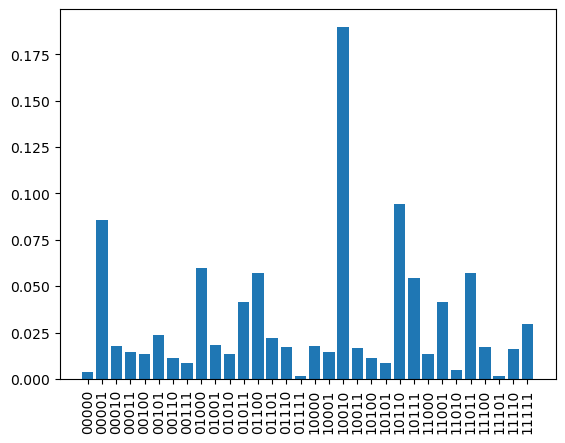

In [107]:
xvalues = [bin(j)[2:].zfill(len(nodes)) for j in range(2**len(nodes)) ]
print(xvalues)
yvalues = probs.tolist()
plt.bar(xvalues, yvalues)
plt.xticks(rotation=90)
plt.show()

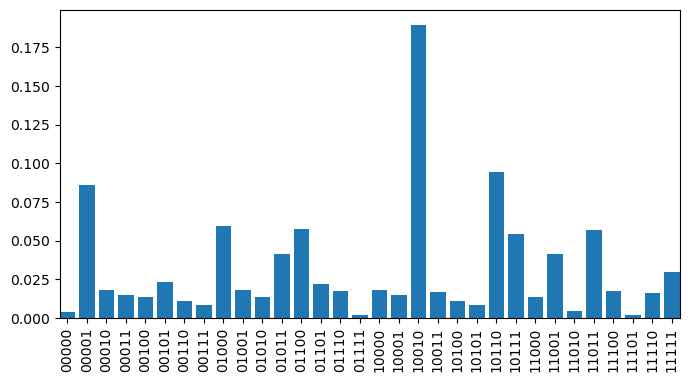

In [108]:
plot_probabilities(probs,all_states= True)

[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
 1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
 3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01
 2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01
 4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01
 8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
 8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
 1.69830420e-01 8.78142503e-01]
Iteration 2: cost = -0.5676 [0.417022   0.70032923 0.01383475 0.28297989 0.12731938 0.09506387
 0.16646453 0.36013168 0.39978275 0.55783089 0.41176396 0.66523472
 0.18448174 0.8581794  0.00747636 0.69028473 0.43728755 0.57869809
 0.15901047 0.21618671 0.81919321 0.98629544 0.33287797 0.71228488
 0.89598765 0.91445481 0.0654458  0.01923158 0.15001376 0.85832958]
Iteration 4: cost = -1.0038 [ 4.17022005e-01  6.80594183e-01  5.68658932e-03  2.65252321e-01
  1.12804665e-01  7.88601005e-02  1.48043786e-01  3.55689595e-01
  3.82571140e-01  5

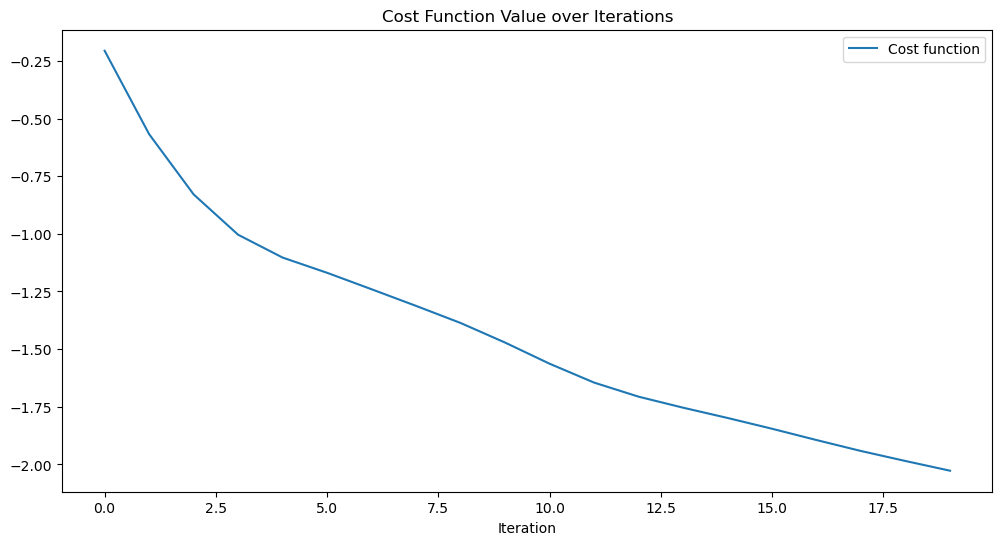

In [109]:
np.random.seed(1)
params = pnp.array(np.random.rand(2*n_layers),requires_grad = True)
print(params)
# Optimize the QAOA parameters

opt = qml.AdamOptimizer(stepsize=0.01)

# Run the optimization
#params[0] = 10
max_iterations = 20
costs = []
for i in range(max_iterations):
    params, cost = opt.step_and_cost(cost_function, params)
    costs.append(cost)
    if (i + 1) % 2 == 0:
        print(f"Iteration {i + 1}: cost = {cost:.4f}",params)
       # drawer = qml.draw(print_ansatz)
        #print(drawer(params))

# Display the optimized parameters and final cost
print("Optimized parameters:", params)
print("Final cost:", cost)

# Plot the cost over iterations
plt.figure(figsize=(12, 6))
plt.plot(costs, label='Cost function')
plt.xlabel('Iteration')
plt.title('Cost Function Value over Iterations')
plt.legend()
plt.show()



In [73]:
costs

[tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True),
 tensor(-0.43286639, requires_grad=True)]

[1 0 0 1 1] 19
[1 0 0 1 1]


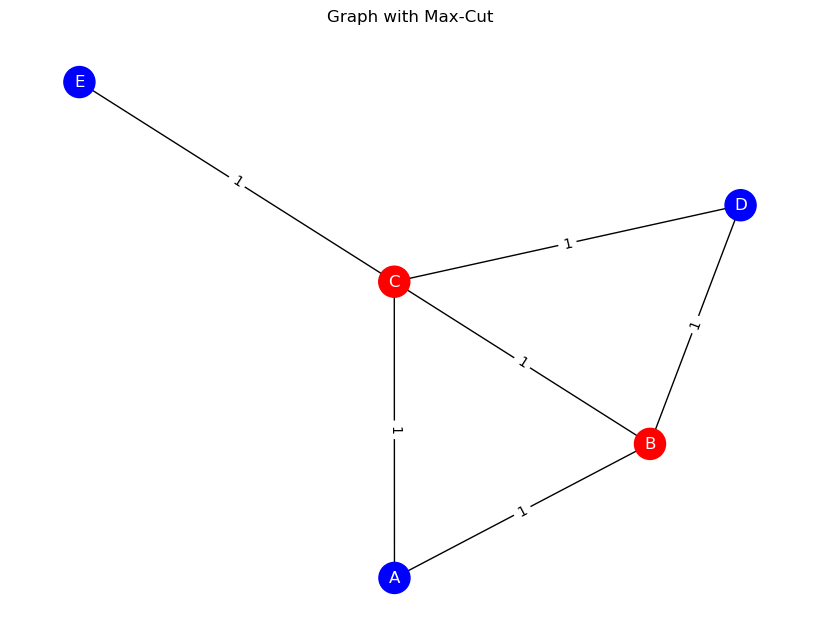

In [110]:
def find_max_cut(G, params):
    bitstring = np.argmax(print_ansatz(params))
    cut = np.array([int(x) for x in f"{bitstring:0{n_qubits}b}"])
    print(cut, bitstring)
    return cut

# Find the Max-Cut
max_cut = find_max_cut(G, params)

print(max_cut)
# Plot the graph with the Max-Cut
colors = ['red' if max_cut[i] == 0 else 'blue' for i in range(n_qubits)]
pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=500, font_color='white')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Graph with Max-Cut")
plt.show()

In [75]:
max_cut

array([1, 1, 0, 1, 1])

Classical solution: {'s0': 1, 's1': -1, 's2': -1, 's3': 1, 's4': 1} 
(colors: [1, 0, 0, 1, 1])
(Minimum energy: -4.0


/var/folders/g3/08f8pgkj1gs3mvbsf29phb1m0000gn/T/ipykernel_27397/2794658833.py:39: DeprecationWarning: Call to deprecated function (or staticmethod) solve_ising. (You should use simulated annealing sampler of dwave-neal directly.) -- Deprecated since version 0.4.0.
  solution = solve_ising(linear, quad)


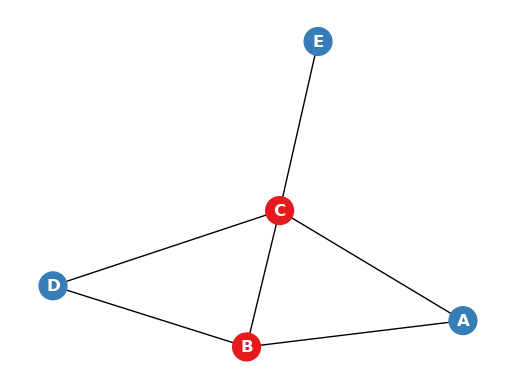

In [111]:
# classical solution using DWave's pyqubo and neal packages
#   (see bottom cells of qml_qaoa_intro.ipynb)
try:
    from pyqubo import Spin, solve_ising
except ImportError:
    print("pyqubo package not found ... it takes a while to get it installed")
    !pip install --quit pyqubo
    from pyqubo import Spin, solve_ising
try:
    import neal
except ImportError:
    print("DWave's neal package not found ... it takes a while to get it installed")
    !pip install --quit neal
    import neal

# build classical Ising Hamiltonian (input: Ising matrix J)
def build_classical_ising(J):
    # define classical spin variables
    spins = []
    N = J.shape[0]
    for ii in range(N):
        spin_name = "s" + str(ii)
        spins.append(Spin(spin_name))
    # build Ising Hamiltonian (here no linear terms nor offsets)
    ham = 0
    for ii in range(N):
        for jj in range(ii, N):
            if J[ii][jj] != 0.0:
                ham += J[ii][jj] * spins[ii] * spins[jj]
    # create Ising model
    return ham.compile()

# solve classical optimization problem 
def solve_classical_ising(J):
    # define and build classical Ising
    model = build_classical_ising(J)
    linear, quad, offset = model.to_ising()
    # solve classical Ising model (ignore offset: doesn't change solution)
    solution = solve_ising(linear, quad)
    # get corresponding energy and color of each vertex
    N = J.shape[0]
    energy_min = 0
    colors = [0 for _ in range(N)]
    for ii in range(N):
        if solution["s" + str(ii)] == 1:
            colors[ii] = 1        
        for jj in range(ii + 1, N):
            energy_min += J[ii][jj] * solution["s" + str(ii)] * solution["s" + str(jj)]
    # obtain colors of each vertex
    return solution, energy_min, colors

# get Ising matrix (distance matrix)
J = nx.to_numpy_array(G)
# run classical algorithm
solution, energy_min, colors_classical = solve_classical_ising(J)
print("Classical solution: {} \n(colors: {})".format(solution, colors_classical))
print("(Minimum energy:", energy_min)

# plot classical solution
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=168421) 
colorlist = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"] 
nx.draw_networkx(G, pos,
        node_color=[colorlist[col] for col in colors_classical],
        node_size=400, font_weight="bold", font_color="w",)
plt.axis("off")
plt.show()

Best solution: {'s3': 0, 's4': 0, 's2': 1, 's1': 1, 's0': 0} 
(colors: [0, 1, 1, 0, 0])


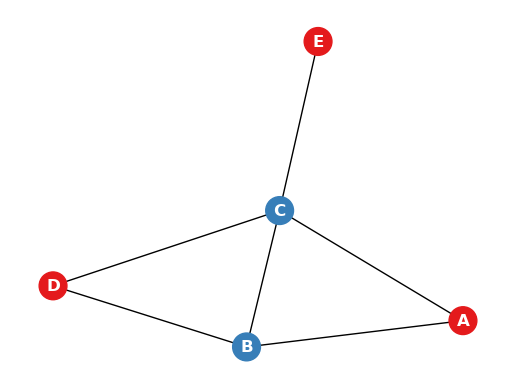

In [92]:
# using simulated annealer 
import neal     #dwave's annealer class
model = build_classical_ising(J)
bqm = model.to_bqm()
sa = neal.SimulatedAnnealingSampler()
sampleset = sa.sample(bqm, num_reads=10)
samples = model.decode_sampleset(sampleset)
best_sample = min(samples, key=lambda s: s.energy)
colors_sa = [0 for _ in range(J.shape[0])]
for s,j in best_sample.sample.items():
    colors_sa[int(s[1:])] = j
print("Best solution: {} \n(colors: {})".format(best_sample.sample,colors_sa))

# plot classical solution
fig, ax = plt.subplots()
pos = nx.spring_layout(G, seed=168421) 
colorlist = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"] 
nx.draw_networkx(G, pos,
        node_color=[colorlist[col] for col in colors_sa],
        node_size=400, font_weight="bold", font_color="w",)
plt.axis("off")
plt.show()

In [98]:
# compare qaoa and class. solutions
print("Partitioning (classical):  ",
          np.array(colors_classical), "or", 
          np.bitwise_not(np.array(colors_classical))+2)
print("Partitioning (sim.anneal.):", np.array(colors_sa))
print("Partitioning (Adam-QAOA):   ", np.array(max_cut))

Partitioning (classical):   [1 0 0 1 1] or [0 1 1 0 0]
Partitioning (sim.anneal.): [0 1 1 0 0]
Partitioning (Adam-QAOA):    [0 1 1 0 1]
